# Testing the CosmoAPI SACC Generation Developement

In [54]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from firecrown.metadata_types import Galaxies, InferredGalaxyZDist
from firecrown.generators.inferred_galaxy_zdist import ZDistLSSTSRDBin, LinearGrid1D
from firecrown.utils import base_model_to_yaml, base_model_from_yaml
from firecrown.metadata_functions import make_all_photoz_bin_combinations, TwoPointHarmonic, TwoPointReal
import firecrown.likelihood.two_point as tp
from firecrown.modeling_tools import ModelingTools
from firecrown.ccl_factory import CCLFactory
from firecrown.updatable import get_default_params
from firecrown.parameters import ParamsMap
import firecrown

import numpy as np
import matplotlib.pyplot as plt
import importlib
import sys

# this is only needed for now:
# FIXME: after packaging, fix this
sys.path.append('../CosmoAPI/')
from two_point_functions import generate_sacc, nz_loader
from api_io import load_yaml_file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
config = load_yaml_file('../test.yaml')
#config = load_yaml_file('../example_yamls/twopcf_generator.yaml')

In [74]:
ell_test = generate_sacc.generate_ell_theta_array_from_yaml(config['probes']['source'], 'ell_bins', dtype=float)
print(len(ell_test))

128


In [75]:
#FIXME: We have to implement this in the yaml
ells = np.unique(np.geomspace(2, 2000, 128).astype(int))
print(ells)

[   2    3    4    5    6    7    8    9   10   11   12   13   14   15
   16   17   18   19   20   21   23   24   25   27   28   30   32   33
   35   37   39   42   44   46   49   52   55   58   61   64   68   72
   76   80   85   90   95  100  106  111  118  124  131  139  146  155
  163  172  182  192  203  215  227  239  253  267  282  298  314  332
  350  370  391  413  436  460  486  513  542  572  604  638  673  711
  751  793  837  884  933  986 1041 1099 1160 1225 1294 1366 1443 1523
 1608 1698 1793 1894 2000]


In [53]:
#FIXME: We have to implement this in the yaml
ells = np.unique(np.geomspace(2, 2000, 128))

# process the probes:
two_pt_function, two_pt_probes = generate_sacc.process_probes_load_2pt(config)
# load all the nzs:
nzs = nz_loader.load_all_nz(config)

# make all two point functions bin combinations:
all_two_point_bins = make_all_photoz_bin_combinations(nzs)
# generate the necessary metadata:
all_two_point_metdata = [two_pt_function(XY=ij, ells=ells) for ij in all_two_point_bins]

# load all the systematics for all probes:
probes = config.get("probes", [])
for p in two_pt_probes:
    probes[p]['loaded_systematics'] = generate_sacc.load_systematics_factory(config['probes'][p]['systematics'])

# prepare all the two point functions:
all_two_point_functions = tp.TwoPoint.from_metadata(
    metadata_seq=all_two_point_metdata,
    wl_factory=probes['source']['loaded_systematics'],
    nc_factory=probes['lens']['loaded_systematics'],
)

All nz_type probes have the same function: TwoPointHarmonic


In [58]:
type(probes['source']['loaded_systematics'])

firecrown.likelihood.weak_lensing.WeakLensingFactory

In [65]:
for p in two_pt_probes:
    print(p, type(probes[p]['loaded_systematics']))
    type_factory = probes[p]['systematics'].get('type')
    if type_factory is "WeakLensingFactory":
        wcfact = probes[p]['loaded_systematics']
    elif type_factory is "NumberCountsFactory":
        ncfact = probes[p]['loaded_systematics']
    else:
        

source <class 'firecrown.likelihood.weak_lensing.WeakLensingFactory'>
WeakLensingFactory
lens <class 'firecrown.likelihood.number_counts.NumberCountsFactory'>
NumberCountsFactory


In [76]:
generate_sacc.prepare_2pt_functions(config)

All nz_type probes have the same function: TwoPointHarmonic


(UpdatableCollection([<firecrown.likelihood.two_point.TwoPoint at 0x30972a360>,
                      <firecrown.likelihood.two_point.TwoPoint at 0x30959b2c0>]),
 [TwoPointHarmonic(XY=TwoPointXY(x=InferredGalaxyZDist(bin_name='source_0.0_0.3_y1', z=array([0.00000000e+00, 5.34057617e-06, 1.06811523e-05, 1.60217285e-05,
         2.13623047e-05, 3.20434570e-05, 4.27246094e-05, 6.40869141e-05,
         8.54492187e-05, 1.28173828e-04, 1.70898437e-04, 2.56347656e-04,
         3.41796875e-04, 5.12695312e-04, 6.83593750e-04, 1.02539062e-03,
         1.36718750e-03, 1.70898437e-03, 2.05078125e-03, 2.39257812e-03,
         2.73437500e-03, 3.41796875e-03, 4.10156250e-03, 4.78515625e-03,
         5.46875000e-03, 6.83593750e-03, 8.20312500e-03, 9.57031250e-03,
         1.09375000e-02, 1.36718750e-02, 1.64062500e-02, 1.91406250e-02,
         2.18750000e-02, 2.73437500e-02, 3.28125000e-02, 3.82812500e-02,
         4.37500000e-02, 4.92187500e-02, 5.46875000e-02, 6.01562500e-02,
         6.56250000e-02

In [40]:
two_pt_function is firecrown.metadata_types.TwoPointHarmonic

True

In [9]:
tools = ModelingTools(ccl_factory=CCLFactory(require_nonlinear_pk=True))
default_values = get_default_params(tools, all_two_point_functions)
params = ParamsMap(default_values)

tools.update(params)
tools.prepare()
all_two_point_functions.update(params)

In [10]:
default_values

{'alphaz': 0.0,
 'm_nu': [],
 'T_CMB': 2.7255,
 'source_0.8_1.1_y1_mult_bias': 1.0,
 'lens_1.0_1.2_y1_bias': 1.5,
 'lens_0.8_1.0_y1_bias': 1.5,
 'sigma8': 0.81,
 'source_0.5_0.8_y1_delta_z': 0.0,
 'source_0.0_0.3_y1_delta_z': 0.0,
 'source_0.3_0.5_y1_delta_z': 0.0,
 'ia_bias': 0.5,
 'source_1.1_3.5_y1_delta_z': 0.0,
 'wa': 0.0,
 'lens_0.6_0.8_y1_bias': 1.5,
 'source_0.5_0.8_y1_mult_bias': 1.0,
 'Omega_k': 0.0,
 'Omega_b': 0.05,
 'lens_0.2_0.4_y1_delta_z': 0.0,
 'lens_0.2_0.4_y1_bias': 1.5,
 'n_s': 0.96,
 'source_0.3_0.5_y1_mult_bias': 1.0,
 'h': 0.67,
 'Neff': 3.044,
 'lens_0.8_1.0_y1_delta_z': 0.0,
 'lens_0.6_0.8_y1_delta_z': 0.0,
 'lens_1.0_1.2_y1_delta_z': 0.0,
 'lens_0.4_0.6_y1_bias': 1.5,
 'source_0.8_1.1_y1_delta_z': 0.0,
 'source_0.0_0.3_y1_mult_bias': 1.0,
 'source_1.1_3.5_y1_mult_bias': 1.0,
 'z_piv': 0.5,
 'w0': -1.0,
 'lens_0.4_0.6_y1_delta_z': 0.0,
 'Omega_c': 0.25}

In [11]:
two_point0 = all_two_point_functions[0]
meta0 = all_two_point_metdata[0]
tv0 = two_point0.compute_theory_vector(tools)

In [12]:
import pandas as pd
two_point_pd_list = []
for two_point, meta in zip(all_two_point_functions, all_two_point_metdata):
    two_point_pd_list.append(
        pd.DataFrame(
            {
                "ell": two_point.ells,
                "Cell": np.abs(two_point.compute_theory_vector(tools)),
                "bin-x": meta.XY.x.bin_name,
                "bin-y": meta.XY.y.bin_name,
                "measurement": meta.get_sacc_name(),
            }
        )
    )

WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error


In [9]:
two_point_pd_list

[      ell          Cell              bin-x              bin-y  \
 0       2  2.062623e-08  source_0.0_0.3_y1  source_0.0_0.3_y1   
 1       3  2.470217e-08  source_0.0_0.3_y1  source_0.0_0.3_y1   
 2       4  2.449080e-08  source_0.0_0.3_y1  source_0.0_0.3_y1   
 3       5  2.299548e-08  source_0.0_0.3_y1  source_0.0_0.3_y1   
 4       6  2.116736e-08  source_0.0_0.3_y1  source_0.0_0.3_y1   
 ..    ...           ...                ...                ...   
 98   1608  2.191593e-11  source_0.0_0.3_y1  source_0.0_0.3_y1   
 99   1698  1.973819e-11  source_0.0_0.3_y1  source_0.0_0.3_y1   
 100  1793  1.775868e-11  source_0.0_0.3_y1  source_0.0_0.3_y1   
 101  1894  1.595114e-11  source_0.0_0.3_y1  source_0.0_0.3_y1   
 102  2000  1.432341e-11  source_0.0_0.3_y1  source_0.0_0.3_y1   
 
             measurement  
 0    galaxy_shear_cl_ee  
 1    galaxy_shear_cl_ee  
 2    galaxy_shear_cl_ee  
 3    galaxy_shear_cl_ee  
 4    galaxy_shear_cl_ee  
 ..                  ...  
 98   galaxy_shea

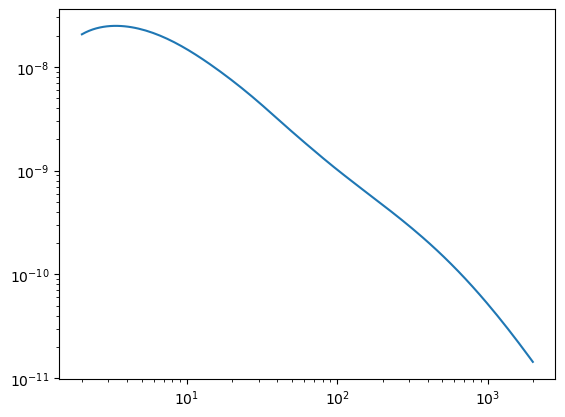

In [13]:
plt.loglog(ells, tv0)

In [14]:
ells

array([   2.        ,    2.11179639,    2.22984199,    2.35448614,
          2.48609766,    2.62506603,    2.77180248,    2.92674123,
          3.09034079,    3.26308526,    3.44548583,    3.63808227,
          3.8414445 ,    4.05617431,    4.28290713,    4.5223139 ,
          4.77510308,    5.04202273,    5.32386269,    5.621457  ,
          5.9356863 ,    6.26748045,    6.61782129,    6.98774555,
          7.37834791,    7.79078423,    8.22627501,    8.68610893,
          9.17164673,    9.68432522,   10.22566152,   10.79725753,
         11.40080474,   12.03808914,   12.71099658,   13.42151834,
         14.17175698,   14.96393261,   15.80038942,   16.68360267,
         17.61618593,   18.60089892,   19.64065558,   20.73853277,
         21.8977793 ,   23.12182563,   24.41429393,   25.77900888,
         27.22000893,   28.74155828,   30.3481595 ,   32.04456682,
         33.83580024,   35.72716038,   37.72424414,   39.83296128,
         42.05955189,   44.4106049 ,   46.89307753,   49.51431